In [112]:
import funciones
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
sharksdf = pd.read_csv("input/GSAF5.csv", encoding = "ISO-8859-1")
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500)

In [148]:
missing_values = sharksdf.isnull().sum()
print(missing_values)


Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
pdf                          0
href formula                 1
href                         3
Case Number.1                0
Case Number.2                0
original order               0
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64


In [257]:
#de esta forma cambiamos los valores de edad a los deseados
#sharksdf.loc[sharksdf.Age == " ", 'Age'] = sharksdf["Age"].mean()
print(sharksdf["Age"].value_counts())

30.0    2774
17.0     150
15.0     150
20.0     145
18.0     145
19.0     140
16.0     136
21.0     117
22.0     113
24.0     105
25.0     102
14.0      98
13.0      92
23.0      81
26.0      81
28.0      80
27.0      79
29.0      76
12.0      71
35.0      67
32.0      65
40.0      57
31.0      53
10.0      51
38.0      47
34.0      45
43.0      43
33.0      42
36.0      41
9.0       38
11.0      38
39.0      37
37.0      37
50.0      36
42.0      36
41.0      34
52.0      34
45.0      32
8.0       29
44.0      29
47.0      28
49.0      27
46.0      25
48.0      25
7.0       23
55.0      20
51.0      19
60.0      16
6.0       15
57.0      14
54.0      14
53.0      13
58.0      12
59.0      11
61.0      11
56.0       9
63.0       9
69.0       8
62.0       8
5.0        7
68.0       6
70.0       6
1.0        5
3.0        4
65.0       4
64.0       4
71.0       3
66.0       3
77.0       3
75.0       2
74.0       2
78.0       2
81.0       1
72.0       1
84.0       1
67.0       1
87.0       1

In [247]:
#Rellenamos los nan con la media de edad
#cambiamos el tipo de edad a float
print(sharksdf["Age"].dtype)
sharksdf["Age"].fillna(sharksdf["Age"].mean(), inplace=True)
sharksdf['Age'] = sharksdf.Age.astype(float)
print(sharksdf.dtypes)

object
Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                        int32
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
Case Number.1             object
Case Number.2             object
original order             int64
Unnamed: 22               object
Unnamed: 23               object
dtype: object


In [259]:
#un df de backup just in case
backupsharksdf = sharksdf
backupsharksdf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16.0,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36.0,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43.0,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,30.0,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,30.0,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


In [267]:
#Unificar los Y/N y dejar los Unknown
sharksdf.loc[sharksdf["Fatal (Y/N)"] == "#VALUE!", 'Fatal (Y/N)'] = "N"
print(sharksdf["Fatal (Y/N)"].value_counts())

N          4327
Y          1552
UNKNOWN      94
Name: Fatal (Y/N), dtype: int64


In [268]:
print(sharksdf["Activity"].value_counts())

Surfing                                               904
Swimming                                              819
Fishing                                               414
Spearfishing                                          321
Bathing                                               153
                                                     ... 
Standing on sandbank                                    1
Attempting to drag hooked shark ashore by its tail      1
Swimming underneath house on pilings                    1
Swimming near life raft                                 1
Resting on body board                                   1
Name: Activity, Length: 1492, dtype: int64


In [269]:
print(sharksdf["Type"].value_counts())

Unprovoked      4386
Provoked         557
Invalid          519
Sea Disaster     220
Boat             200
Boating          110
Name: Type, dtype: int64


In [271]:
#Quito estas columnas ya que o son repetidas o pueden ser derivables a partir de otros datos
cleaned_sharksdf = sharksdf.drop(columns=["href formula","href","Case Number.1","Case Number.2","Unnamed: 22","Unnamed: 23"])
cleaned_sharksdf.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16.0,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36.0,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43.0,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,30.0,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,30.0,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,5989


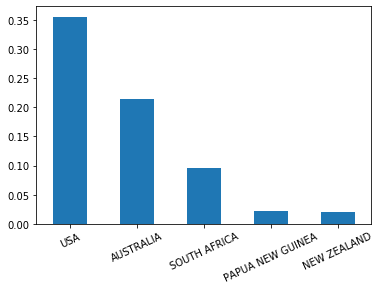

In [108]:
#Muestra los 5 paises con más ataques de tiburones
countryNums = sharksdf["Country"].value_counts(normalize=True)
threshold = 0.02
mask = countryNums > threshold
tail_prob = countryNums.loc[~mask].sum()
countryNums = countryNums.loc[mask]
#countryNums['other'] = tail_prob
countryNums.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

In [109]:
#sharksdf["Year"]=sharksdf["Date"].apply(lambda x: fixYear if x == 0 else 0)

In [111]:
#sharksdf["Year"].value_counts(ascending=True)

#filtered_dataframe = sharksdf[sharksdf["Year"] == 0]
sharksdf


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,0,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,0,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,ND.0005,Before 1903,<function fixYear at 0x115A6930>,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,FATAL,Y,NaN,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6,NaN,NaN
5988,ND.0004,Before 1903,<function fixYear at 0x115A6930>,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,FATAL,Y,NaN,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5,NaN,NaN
5989,ND.0003,1900-1905,<function fixYear at 0x115A6930>,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,FATAL,Y,NaN,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4,NaN,NaN
5990,ND.0002,1883-1889,<function fixYear at 0x115A6930>,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,FATAL,Y,NaN,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3,NaN,NaN


In [ ]:
sharkslocation = shortsharksdf[["Country","Area","Location"]]
sharks

In [8]:
sharksdf["Year"].value_counts(ascending=True)

1595      1
1822      1
1818      1
1758      1
1742      1
       ... 
2013    122
0       124
2014    125
2011    128
2015    139
Name: Year, Length: 232, dtype: int64